<a href="https://colab.research.google.com/github/debitCredit/machine-learning/blob/main/Vision-beer-or-wine-glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -Uqq fastai

     |████████████████████████████████| 225 kB 15.0 MB/s 


In [4]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [5]:
urls = search_images('beer glass photos', max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/b06caef0-c926-46c0-9c3c-d00b77048592_1.6374d28ce2f481f8fee8777abf267392.jpeg'

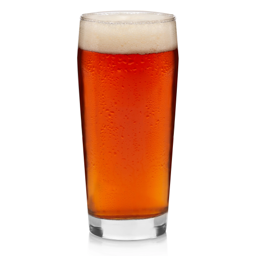

In [6]:
from fastdownload import download_url
dest = 'beer_glass.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

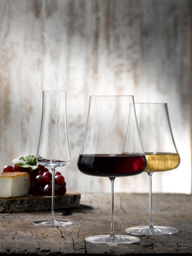

In [7]:
download_url(search_images('wine glass photos', max_images=1)[0], 'wine_glass.jpg', show_progress=False)
Image.open('wine_glass.jpg').to_thumb(256,256)

In [8]:
searches = 'wine glass','beer glass'
path = Path('wine_or_beer_glass')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

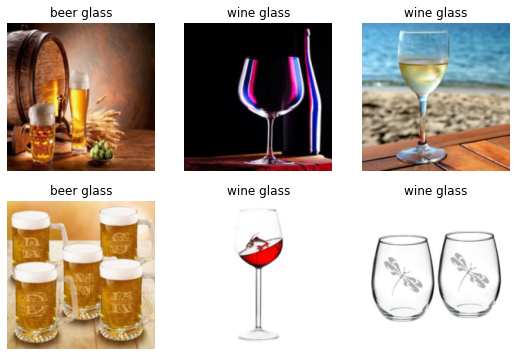

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.066884,0.707794,0.276316,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.377777,0.230318,0.105263,00:02
1,0.245723,0.075080,0.026316,00:02
2,0.173506,0.072774,0.026316,00:02


In [14]:
is_beer_glass,_,probs = learn.predict(PILImage.create('beer_glass.jpg'))
print(f"This is a: {is_beer_glass}.")
print(f"Probability it's a beer glass: {probs[0]:.4f}")

This is a: beer glass.
Probability it's a beer glass: 1.0000
